In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [3]:
df = pd.read_csv("spotify_millsongdata.csv")
df.head()


,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [4]:
df.shape


(57650, 4)

In [5]:
df.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [6]:
df.describe(include='all')



,artist,song,link,text
count,57650,57650,57650,57650
unique,643,44824,57650,57494
top,Donna Summer,Have Yourself A Merry Little Christmas,/a/abba/ahes+my+kind+of+girl_20598417.html,I just came back from a lovely trip along the ...
freq,191,35,1,6


In [7]:
df.columns


Index(['artist', 'song', 'link', 'text'], dtype='object')

In [8]:
df = df[['song', 'artist', 'text']]
df.head()


,song,artist,text
0,Ahe's My Kind Of Girl,ABBA,"Look at her face, it's a wonderful face \nAnd..."
1,"Andante, Andante",ABBA,"Take it easy with me, please \nTouch me gentl..."
2,As Good As New,ABBA,I'll never know why I had to go \nWhy I had t...
3,Bang,ABBA,Making somebody happy is a question of give an...
4,Bang-A-Boomerang,ABBA,Making somebody happy is a question of give an...


In [9]:
df.isnull().sum()


song      0
artist    0
text      0
dtype: int64

In [10]:
df.dropna(inplace=True)


In [11]:
df.duplicated().sum()


np.int64(0)

In [12]:
df.drop_duplicates(inplace=True)


In [13]:
df['lyrics_length'] = df['text'].apply(len)
df[['lyrics_length']].describe()


,lyrics_length
count,57650.000000
mean,1179.504892
std,575.705050
min,400.000000
25%,784.000000
50%,1052.000000
75%,1415.000000
max,3997.000000


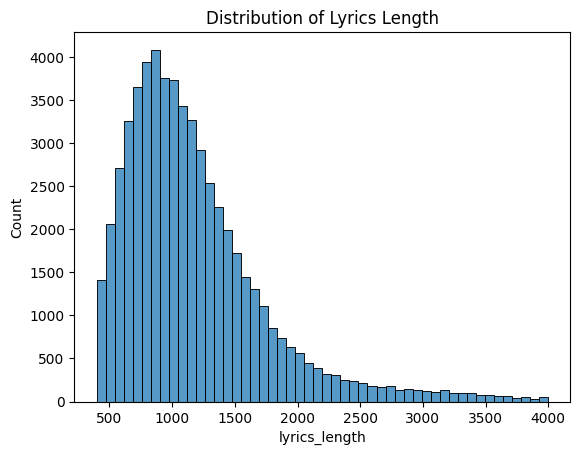

In [14]:
plt.figure()
sns.histplot(df['lyrics_length'], bins=50)
plt.title("Distribution of Lyrics Length")
plt.show()


In [16]:
df['combined_text'] = df['song'] + " "+ df['artist'] + " " + df['text']
df[['combined_text']].head()


,combined_text
0,"Ahe's My Kind Of Girl ABBA Look at her face, i..."
1,"Andante, Andante ABBA Take it easy with me, pl..."
2,As Good As New ABBA I'll never know why I had ...
3,Bang ABBA Making somebody happy is a question ...
4,Bang-A-Boomerang ABBA Making somebody happy is...


In [17]:
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=5000
)

tfidf_matrix = tfidf.fit_transform(df['combined_text'])


In [18]:
tfidf_matrix.shape


(57650, 5000)

In [20]:

def recommend_song(song_name, top_n=5):
    if song_name not in df['song'].values:
        return "Song not found"

    idx = df[df['song'] == song_name].index[0]

   
    sim_scores = cosine_similarity(
        tfidf_matrix[idx],
        tfidf_matrix
    ).flatten()

  
    similar_indices = sim_scores.argsort()[::-1][1:top_n+1]

    recommendations = []
    for i in similar_indices:
        recommendations.append(
            (df.iloc[i]['song'], df.iloc[i]['artist'])
        )

    return recommendations


In [21]:
recommend_song("Imagine", 5)


[('Imagine', 'Our Lady Peace'),
 ('Imagine', 'The Beatles'),
 ('Imagine', "Guns N' Roses"),
 ('Imagine', 'Diana Ross'),
 ('Imagine', 'Avril Lavigne')]

In [22]:
def recommend_by_mood(mood_text, top_n=5):
    mood_vector = tfidf.transform([mood_text])

    similarity_scores = cosine_similarity(
        mood_vector,
        tfidf_matrix
    ).flatten()

    top_indices = similarity_scores.argsort()[::-1][:top_n]

    return df.iloc[top_indices][['song', 'artist']]


In [23]:
recommend_by_mood("sad romantic slow", 5)


,song,artist
24929,Virgin,Beautiful South
14672,So Sad - The Riverboat Song B - Side,Ocean Colour Scene
17860,Isn't It Romantic,Rod Stewart
14261,Easy Slow,Nitty Gritty Dirt Band
49819,The Tourist,Radiohead


In [24]:
recommend_by_mood("happy fast", 5)


,song,artist
40549,Happy,Kirsty Maccoll
14772,Happy,Oingo Boingo
9834,Happy To Give,Journey
40291,Happy With What You Have To Be Happy With,King Crimson
57033,Stupidly Happy,XTC


In [25]:
recommend_by_mood("upset slow sad", 5)

,song,artist
14672,So Sad - The Riverboat Song B - Side,Ocean Colour Scene
14261,Easy Slow,Nitty Gritty Dirt Band
49819,The Tourist,Radiohead
45802,"Slow, Love, Slow",Nightwish
45894,Mississippi Goddam,Nina Simone


In [26]:
df.to_csv("cleaned_songs.csv", index=False)
